Modelling Volume
=======================

One of the core things that the previous model definitely failed on was that it would have learned based on the volume, or power of each frequency in the signal. This is true for human hearing as well, but it's relative. The sound of a flute down the hall is as identifiable as a flute 1 meter from our ears. We recognise the sound of the flute based on the powers of frequencies relative to each other, irrepective of the baseline power. We need to make sure that we can model the signal so that the same spikes happen whether the sound is quiet or loud. Here we try to reduce the problem to that and model that interaction.

At least with respect to snntorch, we have two primary models for a signaling neuron: an LIF and a Synaptic LIF. In an LIF neuron, the signal at time t is determined by:

$t_n = \beta t_{n-1} + I_{t}$

and if $t_n$ is at or above the threshold, then the output is 1 with t being reset either by subtracting the threshold or resetting to 0.

In a Synaptic LIF neuron, the signal at time t is determined by:

$t_n = \beta t_{n-1} + \alpha I_{t}$

With the same rules.

In snntorch, backpropagation can be used to adjust the threshold, alpha, and beta, preferrably via a surrogate gradient function that emulates the binary output based on the membrane potential.

# Volume Agnostic Firing

An initial consideration for this might be that you preprocess the signal and normalise the whole thing on a 0-1 scale, and by doing this, different volumes will still normalise to the same general value range. This actually might be a viable approach as this anecdotally feels a bit like how human hearing works. If there's a loud sound in one frequency band, it can still cause us to not hear a quieter sound in another frequency band. But in order for this model to pan out, we also have to include the sensitivity gradients over frequencies in terms of human perception. That is, we are more sensitive to some frequencies than others so a tone plyaing at an extremely low frequency with an amplitude twice as strong as a sound in a higher frequency may still not drown out that higher frequency, because we are more sensitive to the higher frequency.

But it's most plausible that what we're looking for is some combination of both some preprocessing normalisation step along with a mechanism to model frequencies against some threshold. But we still need to be capable of interpreting relative amplitude differences between signals. With a firing neuron, the only way to do this is by modelling spike frequency based on the amplitude. Which is conveniently what happens anyway. So for this, we'll explore methods to trigger spike trains that always fire given some threshold, but fire more frequently for higher amplitudes.

To model the firing rate, we consider the fact that ultimately these impulses are driven by small hairs in the cochlea that are diven to move by the actual vibrations caused by the pressure changes in the ear canal. So in terms of the firing frequency, intuitively we can say that the firing rate can be no higher than the frequency itself. That is, a frequency of 30Hz couldn't be firing more than 30x per second.

In [60]:
!pip install torch==1.11 snntorch librosa numpy seaborn --extra-index-url https://download.pytorch.org/whl/cu113

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import snntorch as snn
import librosa as lr

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


# A continuous mel scale layer

We start with a continuous mel scale layer that takes a raw audio signal and outputs a tensor with the mel scale amplitudes. The output is converted to the frequency domain in 1 millisecond segments according to the sample rate that the layer was constructed with. The forward pass accepts the sample rate of the sample which is then rescaled to the rate of the layer. Then the mel scaled STFT is captured in 3 logarithmically sized segments. At the end, the scales are merged together to capture 768 mel scaled frequency values per millisecond of the audio.

It takes care of partial buffering etc so that no matter how the raw signal is fed in, it comes out in a continuious stream of 100ms chunks with per millisecond frequencies.

torch.Size([1, 1024, 925])


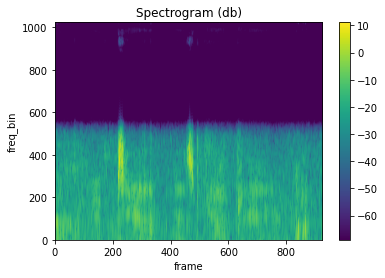

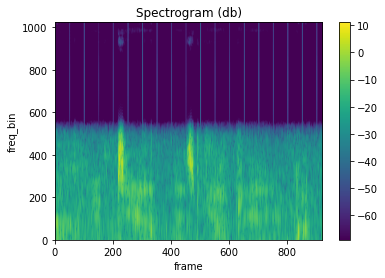

In [544]:

class ContinuousMelScale(nn.Module):
    def __init__(self, sr=44100, bins=3):
        super().__init__()
        
        # the sample rate to use for the audio
        self._sr = sr
        self._resamplers = {}
        self._buffer = None
        self._unused = 0
 
        # we need to capture 1/10th of a second
        # to manage that, we need an fft size that will 
        # capture that frequency which means we need to 
        # double it for the nyquist frequency
        self._n_fft = int(self._sr / 5)
        
        # but we want to capture changes in size up to
        # 20Khz. So we do the same thing for the upper limit
        self._window_shift = int(self._sr / 500)
        
        self._mspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=self._sr,
            n_fft=self._n_fft,
            win_length=self._window_shift * 2,
            hop_length=self._window_shift,
            n_mels=1024,
            f_min=2000,
            f_max=20000)
        
    def reset(self):
        self._unused = 0
        self._buffer = None
        
    def forward(self, x, sr=44100, final=False):
        # resample the audio if it doesn't match
        # the sample rate
        if sr != self._sr:
            if not sr in self._resamplers:
                self._resamplers[sr] = torchaudio.transforms.Resample(
                    orig_freq=sr, 
                    new_freq=self._sr)
                
            # use round to get the correct resampled
            # size - since the resample will generate a whole
            # sample for a partial, even if it's 0.0001
            size = round((x.shape[-1] / sr) * self._sr)
            x = self._resamplers[sr](x)
            x = x[..., :size]
         
        # we first incorporate the buffer
        # into the signal. The buffer will carry
        # extra signal which we didn't evaluate from
        # the previous run
        origsize = x.shape[-1] + self._unused
        if self._buffer is not None:
            x = torch.concat((self._buffer, x), dim=len(x.shape) - 1)
        
        # align the sample to the high frequency window. If there are extra
        # we will include them in the buffer
        keep = origsize % (self._window_shift * 2)
        self._unused = keep
        if keep:
            # if this is the final block, just pad with zeros, otherwise let the rest
            # go to the buffer
            if final:
                extra = (self._window_shift * 2) - keep
                x1 = F.pad(x, ([0] * (len(x.shape) - 1)) + [extra], value=0)
                origsize += extra
            else:
                x1 = x[..., :-keep]
                origsize -= keep
        else:
            x1 = x
 
        if x1.shape[-1] < self._n_fft:
            mel = torch.zeros(list(x1.shape[:-1]) + [1024, 0])
            self._buffer = x
            self._unused = origsize
        else:
            mel = self._mspec(x1)[..., :-1]
            keep = min(self._n_fft, x.shape[-1])
            self._buffer = x[..., -keep:]
            
        # keep the last low size buffer
        skip_samples = x1.shape[-1] - origsize
        skip_size = int(skip_samples / self._window_shift)
        
        self._unused += self._window_shift
        return mel[..., skip_size:-1]

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(lr.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
    
audio, sr = lr.load('data/what_time.wav')
audio = torch.tensor(audio.reshape(1, audio.shape[0]))

model = ContinuousMelScale()
model.eval()

with torch.no_grad():
    spec = model.forward(audio, sr, True)
    plot_spectrogram(spec[0])
    
with torch.no_grad():
    model.reset()
    signal = torch.zeros((1, 1024, 0))
    for i in range(0, audio.shape[1], 2205):
        spec = model.forward(audio[:, i:i+2205], sr, i + 2205 >= audio.shape[1])
        signal = torch.concat((signal, spec), dim=2)
        
    plot_spectrogram(signal[0])

After tons of digging I finally realised that resampling causes artefacts at the end of blocks when the sound is incrementally processed. This appears to be due to the fact that the resampling algorithm actually converts the sample to the frequency domain and converts back at the new sample rate. This can cause a phase shift which screws up the end of the window. This may end up being problematic.

When I build the final product, I may need to do this myself by building a custom pipeline that figures out the phase of the previous resampled block and adjusts the phase of the resampled subsequent block. But I'm going to punt on that because I always have the option of resampling all of my whole samples to match the model up front.